In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

import numpy as np
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchsummary import summary

from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import cv2
from matplotlib.pyplot import imshow
from PIL import Image
import matplotlib.pyplot as plt




In [0]:
#mount google drive
from google.colab import drive
drive.mount('/gdrive')

gdrive = '/gdrive/My\ Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!tar -xf $gdrive/dataset.tar.gz

#Block

In [0]:
#block of a wnet model
class Block(nn.Module):
    def __init__(self, in_filters, out_filters, seperable=True):
        super(Block, self).__init__()
        
        if seperable:
            
            self.spatial1=nn.Conv2d(in_filters, in_filters, kernel_size=3, groups=in_filters, padding=1)
            self.depth1=nn.Conv2d(in_filters, out_filters, kernel_size=1)
            
            self.conv1=lambda x: self.depth1(self.spatial1(x))
            
            self.spatial2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1, groups=out_filters)
            self.depth2=nn.Conv2d(out_filters, out_filters, kernel_size=1)
            
            self.conv2=lambda x: self.depth2(self.spatial2(x))
            
        else:
            
            self.conv1=nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
            self.conv2=nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
        
        self.batchnorm1=nn.BatchNorm2d(out_filters)
        self.batchnorm2=nn.BatchNorm2d(out_filters)

    def forward(self, x):
        
        x=self.batchnorm1(self.conv1(x)).clamp(0)
        
        x=self.batchnorm2(self.conv2(x)).clamp(0)
        
        return x


#Encoder and Decoder

In [0]:
#encoder
class UEnc(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        super(UEnc, self).__init__()
        
        self.enc1=Block(in_chans, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, squeeze, kernel_size=(1, 1))
        
    def forward(self, x):
        
        enc1=self.enc1(x)
        
        enc2=self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3=self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4=self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle=self.middle(F.max_pool2d(enc4, (2,2)))
        
        
        up1=torch.cat([enc4, self.up1(middle)], 1)
        dec1=self.dec1(up1)
        
        up2=torch.cat([enc3, self.up2(dec1)], 1)
        dec2=self.dec2(up2)
        
        up3=torch.cat([enc2, self.up3(dec2)], 1)
        dec3=self.dec3(up3)
        
        up4=torch.cat([enc1, self.up4(dec3)], 1)
        dec4=self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final

class UDec(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3):
        super(UDec, self).__init__()
        
        self.enc1=Block(squeeze, ch_mul, seperable=False)
        self.enc2=Block(ch_mul, 2*ch_mul)
        self.enc3=Block(2*ch_mul, 4*ch_mul)
        self.enc4=Block(4*ch_mul, 8*ch_mul)
        
        self.middle=Block(8*ch_mul, 16*ch_mul)
        
        self.up1=nn.ConvTranspose2d(16*ch_mul, 8*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1=Block(16*ch_mul, 8*ch_mul)
        self.up2=nn.ConvTranspose2d(8*ch_mul, 4*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2=Block(8*ch_mul, 4*ch_mul)
        self.up3=nn.ConvTranspose2d(4*ch_mul, 2*ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3=Block(4*ch_mul, 2*ch_mul)
        self.up4=nn.ConvTranspose2d(2*ch_mul, ch_mul, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4=Block(2*ch_mul, ch_mul, seperable=False)
        
        self.final=nn.Conv2d(ch_mul, in_chans, kernel_size=(1, 1))
        
    def forward(self, x):
        
        enc1 = self.enc1(x)
        
        enc2 = self.enc2(F.max_pool2d(enc1, (2, 2)))
        
        enc3 = self.enc3(F.max_pool2d(enc2, (2,2)))
        
        enc4 = self.enc4(F.max_pool2d(enc3, (2,2)))
        
        
        middle = self.middle(F.max_pool2d(enc4, (2,2)))
        
        
        up1 = torch.cat([enc4, self.up1(middle)], 1)
        dec1 = self.dec1(up1)
        
        up2 = torch.cat([enc3, self.up2(dec1)], 1)
        dec2 = self.dec2(up2)
        
        up3 = torch.cat([enc2, self.up3(dec2)], 1)
        dec3 =self.dec3(up3)
        
        up4 = torch.cat([enc1, self.up4(dec3)], 1)
        dec4 = self.dec4(up4)
        
        
        final=self.final(dec4)
        
        return final



#Wnet

In [0]:
class WNet(nn.Module):
    def __init__(self, squeeze, ch_mul=64, in_chans=3, out_chans=1000):
        super(WNet, self).__init__()
        #output channels
        if out_chans==1000:
            out_chans=in_chans
        self.UEnc=UEnc(squeeze, ch_mul, in_chans)
        self.UDec=UDec(squeeze, ch_mul, out_chans)
    def forward(self, x, returns='both'):
        
        enc = self.UEnc(x)
        
        if returns=='enc':
            return enc
        
        dec=self.UDec(F.softmax(enc, 1))
        
        if returns=='dec':
            return dec
        
        if returns=='both':
            return enc, dec
        
        else:
            raise ValueError('Invalid returns, returns must be in [enc dec both]')

In [0]:
#value of k is 4 
wnet_model = WNet(4).cuda()
#summary of model
summary(wnet_model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
            Conv2d-3         [-1, 64, 224, 224]          36,928
       BatchNorm2d-4         [-1, 64, 224, 224]             128
             Block-5         [-1, 64, 224, 224]               0
            Conv2d-6         [-1, 64, 112, 112]             640
            Conv2d-7        [-1, 128, 112, 112]           8,320
       BatchNorm2d-8        [-1, 128, 112, 112]             256
            Conv2d-9        [-1, 128, 112, 112]           1,280
           Conv2d-10        [-1, 128, 112, 112]          16,512
      BatchNorm2d-11        [-1, 128, 112, 112]             256
            Block-12        [-1, 128, 112, 112]               0
           Conv2d-13          [-1, 128, 56, 56]           1,280
           Conv2d-14          [-1, 256,

#Data Loader

In [0]:
dataset_folder = './Dataset'
input_size = 224
b_size = 4
#dataset transformation
composed_transform = transforms.Compose([transforms.Scale((input_size,input_size)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(dataset_folder, transform = composed_transform)
#loading the dataset
data = torch.utils.data.DataLoader(dataset,
                                          batch_size = b_size,
                                          shuffle = True,
                                          num_workers = 4)
#optimizer
optimizer2 = optim.SGD(wnet_model.parameters(), lr=0.001)



/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:208: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


#Naive Model

In [0]:
#naive model training
def naive_model(model, optimizer, data , epochs,device , psi=0.5):
  steps = 0
  #number of epochs
  for epoch in range(epochs):
    recons_loss = 0.0
    model.train()
    #iterate over all training data
    for ii, (inputs, labels) in enumerate(data):
      steps+=1
      inputs, labels = inputs.to(device), labels.to(device)
      #train encoder
      enc = model(inputs, returns='enc')
      optimizer.step()
      #clear grads
      optimizer.zero_grad()
      #train decoder
      dec = model(inputs, returns='dec')
      rec_loss=torch.mean(torch.pow(torch.pow(inputs, 2) + torch.pow(dec, 2), 0.5))*(1-psi)
      rec_loss.backward()
      optimizer.step()
      #reconstruction loss
      recons_loss += rec_loss.item() * inputs.size(0)
    recons_loss /= len(data.dataset)
    #free the cuda memory
    torch.cuda.empty_cache()
    print('Epoch ', epoch+1, ' : Reconstruction Loss = ',recons_loss)
  return model

In [0]:
model = naive_model(wnet_model, optimizer2, data, epochs = 2, device = 'cuda')

Epoch  1  : Reconstruction Loss =  0.6531125355649877
Epoch  2  : Reconstruction Loss =  0.645685190477489


In [0]:
path = '/gdrive/My Drive/wnet_naive.mdl'
torch.save(model.state_dict(), path)

In [0]:
model.load_state_dict(torch.load(path))

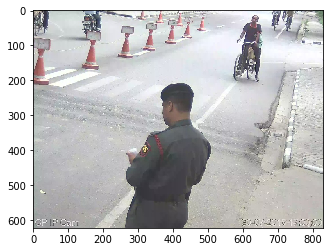

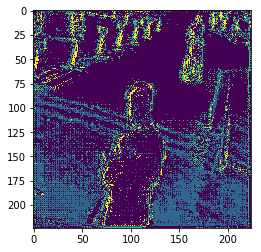

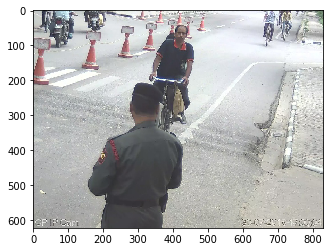

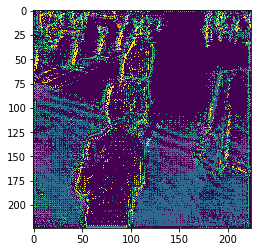

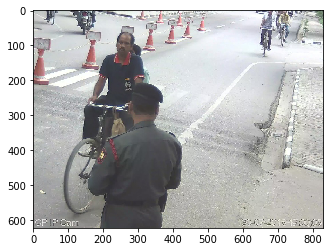

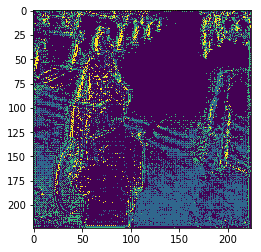

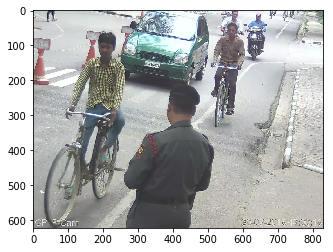

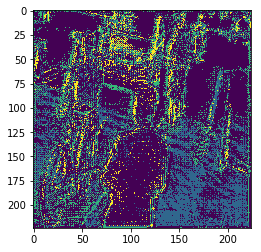

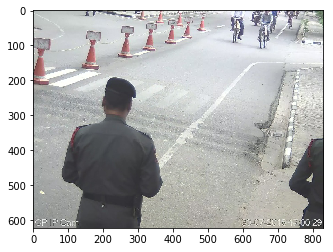

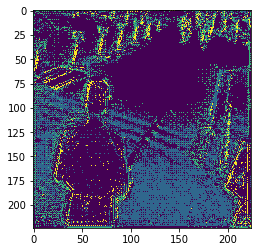

In [0]:
#prediction of naive model
model.eval()
images = ['00001','00078','00103','00285','00538']
for i in images:
  im = Image.open('/content/Dataset/camera4/JPEGImages/'+i+'.jpg')
  plt.imshow(im)
  plt.show()
  trans_img = composed_transform(im).view(1,3,224,224).cuda()
  # model.eval()
  #prediction 
  segments = model(trans_img, returns ='enc')
  _, segment_type = torch.max(segments, dim = 1)
  segments = segment_type.squeeze(0).cpu().numpy()
  plt.imshow(segments)
  plt.show()

#Soft Normalized Cut Loss Model

In [0]:
#verical gradient
vertical_sobel=torch.nn.Parameter(torch.from_numpy(np.array([[[[1,  0,  -1], 
                                            [1,  0,  -1], 
                                            [1,  0,  -1]]]])).float().cuda(), requires_grad=False)
#horizontal gradient
horizontal_sobel=torch.nn.Parameter(torch.from_numpy(np.array([[[[1,   1,  1], 
                                              [0,   0,  0], 
                                              [-1 ,-1, -1]]]])).float().cuda(), requires_grad=False)

In [0]:
# gradient regularization for soft normalized cut loss
def gradient_regularization(softmax, device='cuda'):
    vert=torch.cat([F.conv2d(softmax[:, i].unsqueeze(1), vertical_sobel) for i in range(softmax.shape[1])], 1)
    hori=torch.cat([F.conv2d(softmax[:, i].unsqueeze(1), horizontal_sobel) for i in range(softmax.shape[1])], 1)
    mag = torch.pow(torch.pow(vert, 2)+torch.pow(hori, 2), 0.5)
    mean=torch.mean(mag)
    return mean

In [0]:
def train_soft_model(model, optimizer, data_loader, epochs, device, psi=0.5):
  steps = 0
  #number of epochs
  for epoch in range(epochs):
    softncut_loss = 0.0
    recons_loss = 0.0
    model.train()
    #iterate over all training data
    for ii, (inputs, labels) in enumerate(data):
      steps+=1
      inputs, labels = inputs.to(device), labels.to(device)
      #train encoder
      enc = model(inputs, returns='enc')
      optimizer.step()
      #clear grads
      optimizer.zero_grad()
      n_cut_loss=gradient_regularization(enc)*psi
      n_cut_loss.backward(retain_graph=True)
      #train decoder
      dec = model(inputs, returns='dec')
      rec_loss=torch.mean(torch.pow(torch.pow(inputs, 2) + torch.pow(dec, 2), 0.5))*(1-psi)
      rec_loss.backward()
      optimizer.step()
      recons_loss += rec_loss.item() * inputs.size(0)
      softncut_loss += n_cut_loss.item() * inputs.size(0)
      #train losses
    recons_loss /= len(data.dataset)
    softncut_loss /= len(data.dataset)
    #clearing cuda memory
    torch.cuda.empty_cache()
    print('Epoch ', epoch+1, ' : Reconstruction Loss = ',recons_loss)
  return model

In [0]:
model2 = train_soft_model(wnet_model, optimizer2, data, epochs = 2, device = 'cuda')

Epoch  1  : Reconstruction Loss =  0.641804145294943
Epoch  2  : Reconstruction Loss =  0.6392203640054773


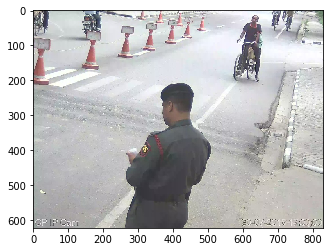

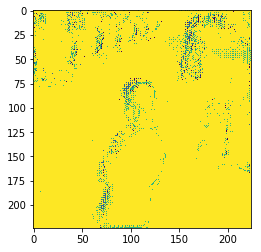

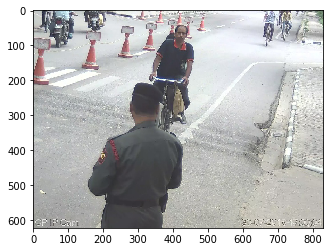

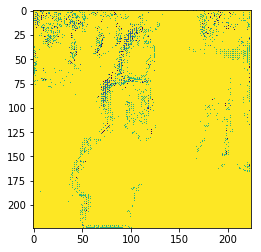

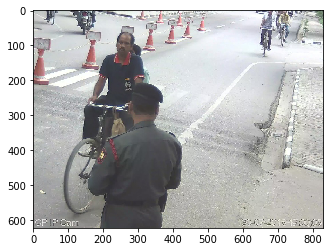

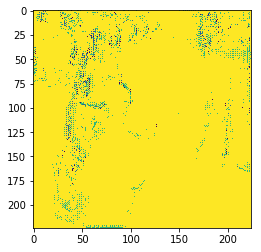

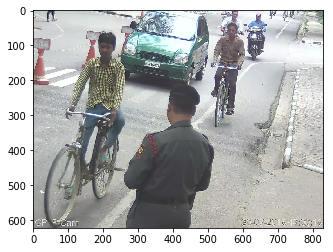

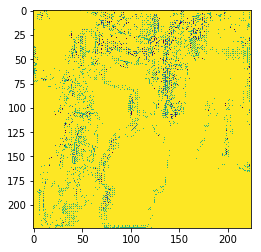

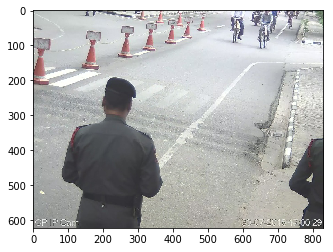

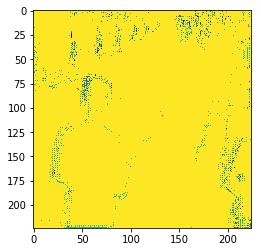

In [0]:
#prediction of naive model
model2.eval()
images = ['00001','00078','00103','00285','00538']
for i in images:
  im = Image.open('/content/Dataset/camera4/JPEGImages/'+i+'.jpg')
  plt.imshow(im)
  plt.show()
  trans_img = composed_transform(im).view(1,3,224,224).cuda()
  # model.eval()
  segments = model2(trans_img, returns ='enc')
  _, segment_type = torch.max(segments, dim = 1)
  segments = segment_type.squeeze(0).cpu().numpy()
  plt.imshow(segments)
  plt.show()

In [0]:
path = '/gdrive/My Drive/wnet_soft.mdl'
torch.save(model2.state_dict(), path)